In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

##  Loading test images

In [2]:
#function to show list of images
def list_images(images, cols = 2, rows = 5, cmap=None):
    """
    Display a list of images in a single figure with matplotlib.
        Parameters:
    """
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        #Use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape) == 2 else cmap
        plt.imshow(image, cmap = cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

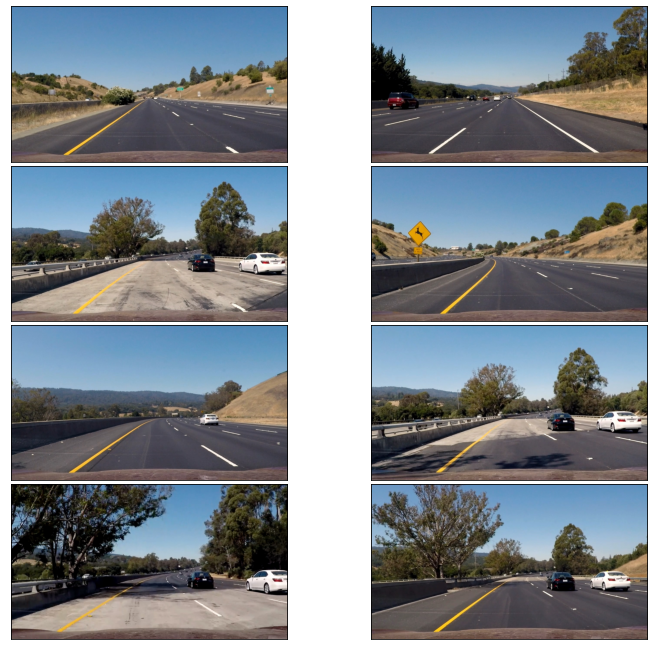

In [3]:
#Reading in the test images
test_images = [plt.imread(img) for img in glob.glob('test_images/*.jpg')]
list_images(test_images)

## Original RGB color selection

In [4]:
def RGB_color_selection(image):
    """
    Apply color selection to RGB images to blackout everything except for white and yellow lane lines.
        Parameters:
    """
    #White color mask
    lower_threshold = np.uint8([200, 200, 200])
    upper_threshold = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower_threshold, upper_threshold)
    
    #Yellow color mask
    lower_threshold = np.uint8([175, 175,   0])
    upper_threshold = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower_threshold, upper_threshold)
    
    #Combine white and yellow masks
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    
    return masked_image

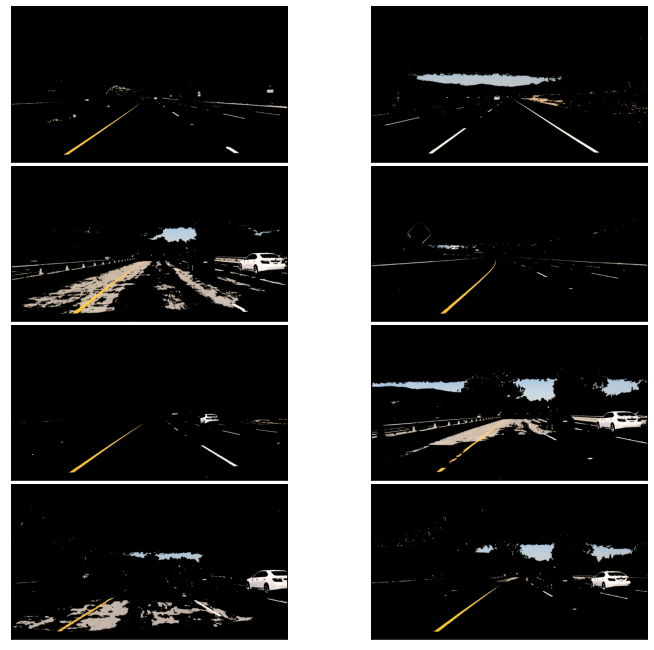

In [5]:
list_images(list(map(RGB_color_selection, test_images)))

## HSL color space

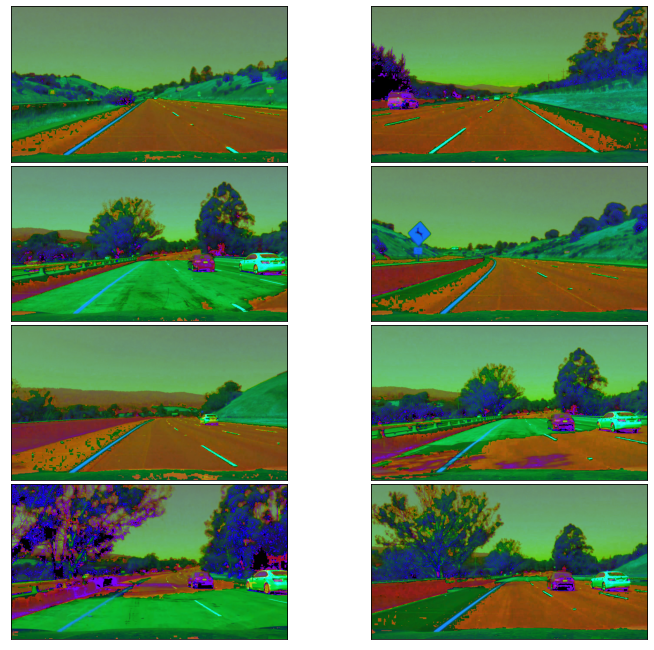

In [6]:
def convert_hsl(image):
    """
    Convert RGB images to HSL.
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

list_images(list(map(convert_hsl, test_images)))

In [7]:
def HSL_color_selection(image):
    """
    Apply color selection to the HSL images to blackout everything except for white and yellow lane lines.

    """
    #Convert the input image to HSL
    converted_image = convert_hsl(image)
    
    #White color mask
    lower_threshold = np.uint8([0, 200, 0])
    upper_threshold = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    #Yellow color mask
    lower_threshold = np.uint8([10, 0, 100])
    upper_threshold = np.uint8([40, 255, 255])
    yellow_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    #Combine white and yellow masks
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    
    return masked_image

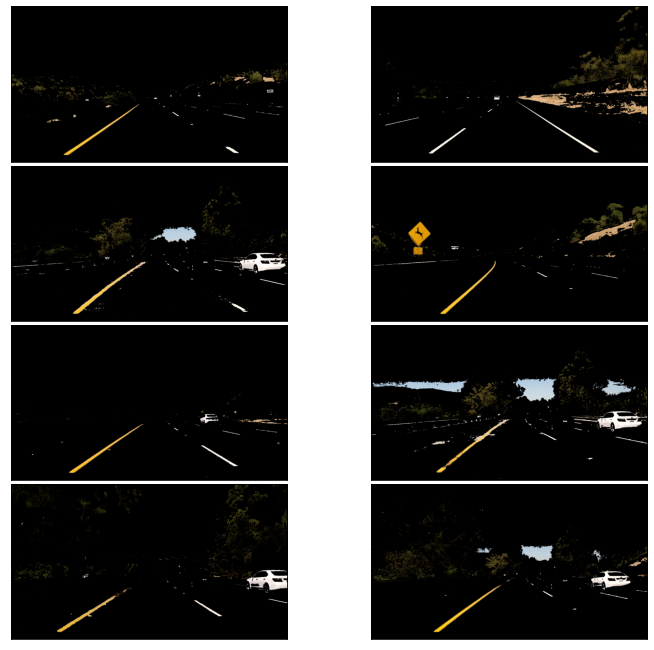

In [8]:
list_images(list(map(HSL_color_selection, test_images)))

Using HSL produces the clearest lane lines of all color spaces. We will use them for the next steps.


Before that we will make CameraCalibration to images

In [9]:
from scripts.CameraCalibration import CameraCalibration # import Calibaration

In [10]:
# Make a list of calibration images
chkboard_images = glob.glob('./camera_cal/calibration*.jpg')

# 
calibration = CameraCalibration(chkboard_images)

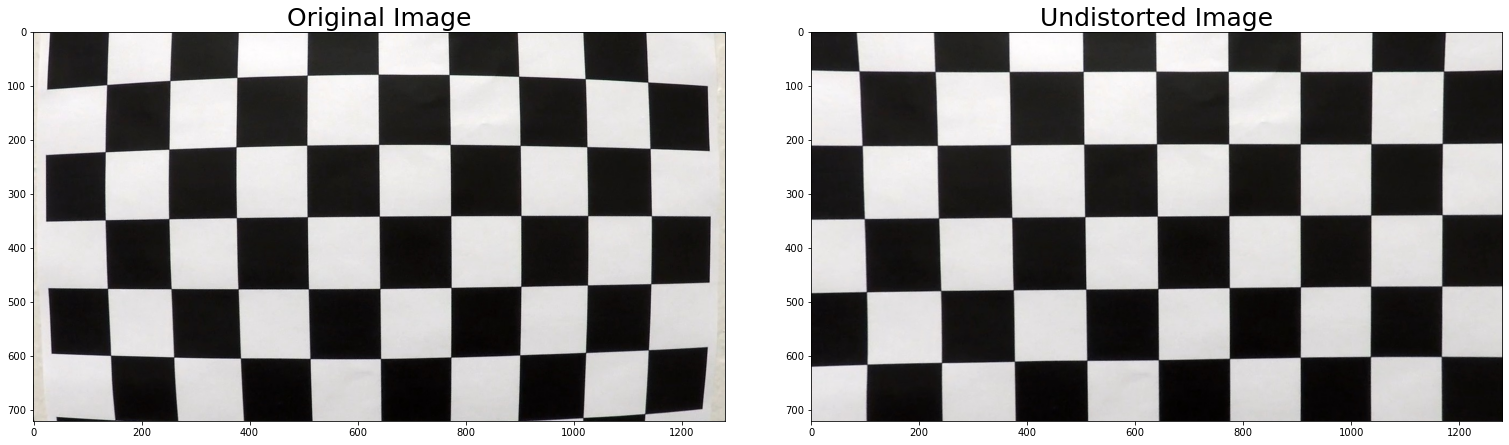

In [11]:
#spllying Camera Calibration on Chessboard images
img = cv2.imread('./camera_cal/calibration1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undimg = calibration.undistort_img(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 6))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(undimg)
ax2.set_title('Undistorted Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Image Thresholding

Color thresholding: Thresholding works well in HSL color space. 
- S > 150 for **yellow** lane line
- L > 180 for **white** lane line

binrary images of yellow and white lane line are combined into `binary_color`

In [12]:
from scripts.Thresholding import ImageColorThres

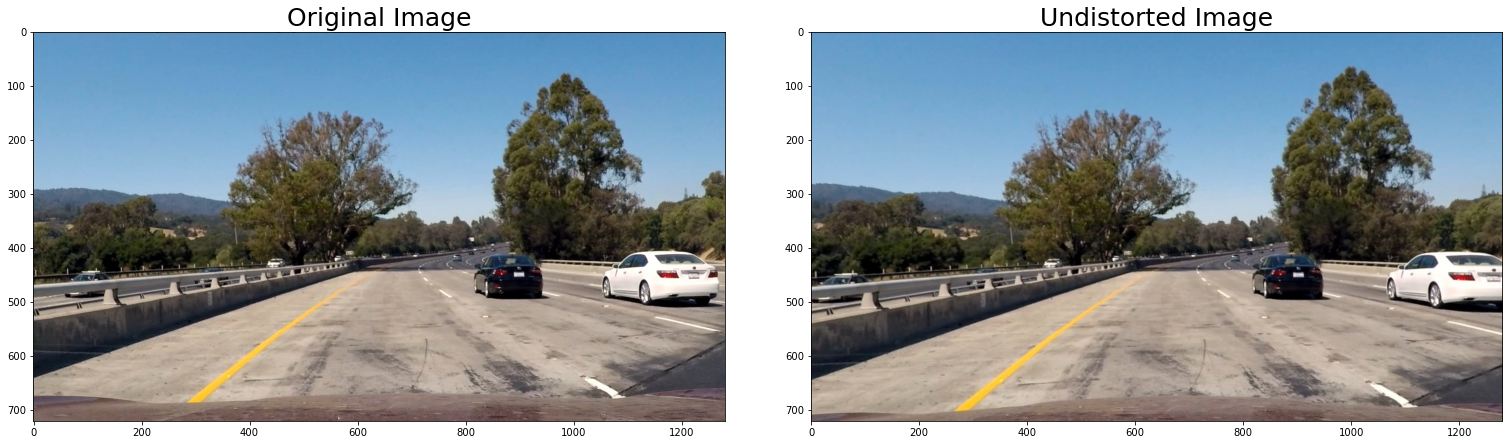

In [78]:
# load road image
img = cv2.imread('./test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert image from BGR to RGB

undimg = calibration.undistort_img(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 6))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(undimg)
ax2.set_title('Undistorted Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [79]:
imshape = undimg.shape # image size
print("image shape: ", imshape)

image shape:  (720, 1280, 3)


Text(0.5, 1.0, 'S')

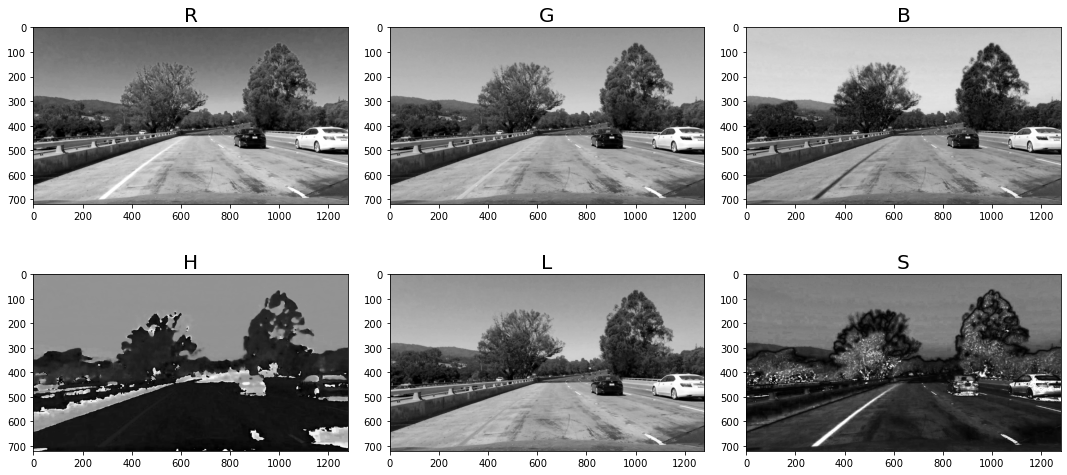

In [80]:
f, axes = plt.subplots(2, 3, figsize=(15, 7))
f.tight_layout()
axes[0,0].imshow(undimg[:,:,0], cmap='gray')
axes[0,0].set_title('R', fontsize=20)

axes[0,1].imshow(undimg[:,:,1], cmap='gray')
axes[0,1].set_title('G', fontsize=20)

axes[0,2].imshow(undimg[:,:,2], cmap='gray')
axes[0,2].set_title('B', fontsize=20)

hls_ = cv2.cvtColor(undimg, cv2.COLOR_RGB2HLS)

axes[1,0].imshow(hls_[:,:,0], cmap='gray')
axes[1,0].set_title('H', fontsize=20)

axes[1,1].imshow(hls_[:,:,1], cmap='gray')
axes[1,1].set_title('L', fontsize=20)

axes[1,2].imshow(hls_[:,:,2], cmap='gray')
axes[1,2].set_title('S', fontsize=20)

In [90]:
# Aplly rigion of interest and RGB2Hsl
roi_vertices = np.array([[(0,720), 
            (1280*7/15, 720*3/5), 
            (1280*8/15, 720*3/5), 
            (1280,720)]],dtype=np.int32)

colorthres = ImageColorThres(undimg, roi_vertices)

yellowline_image = colorthres.thresholding_onechannel('S', 150, 255) # yellow for S channel

whiteline_image  = colorthres.thresholding_onechannel('L', 200, 255) # white for L channel
    


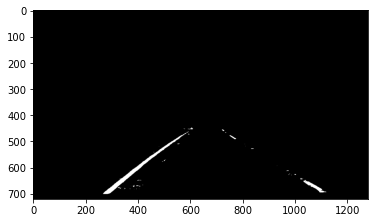

In [91]:
# combine white and yellow using maximum
binary_color = np.zeros_like(yellowline_image)
binary_color = np.maximum(yellowline_image, whiteline_image) # combine white and yellow using maximum

plt.imshow(binary_color , cmap ='gray')

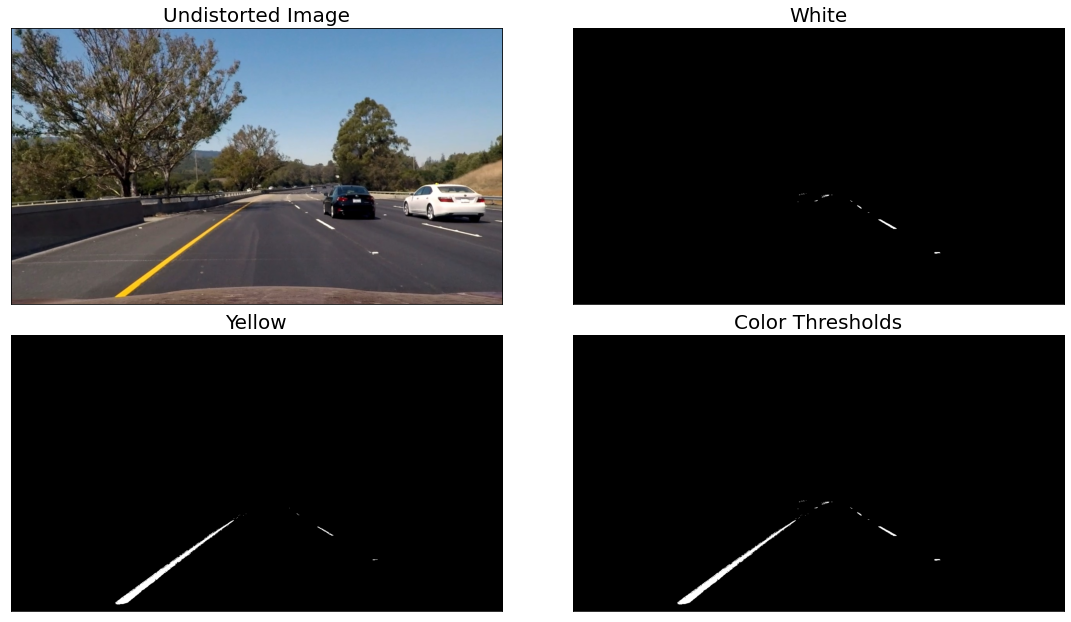

In [34]:
f, axes = plt.subplots(2, 2, figsize=(15, 9))
f.tight_layout()
axes[0,0].imshow(undimg)
axes[0,0].set_title('Undistorted Image', fontsize=20)

axes[1,0].imshow(yellowline_image, cmap='gray')
axes[1,0].set_title('Yellow', fontsize=20)

axes[0,1].imshow(whiteline_image, cmap='gray')
axes[0,1].set_title('White', fontsize=20)

axes[1,1].imshow(binary_color, cmap='gray')
axes[1,1].set_title('Color Thresholds', fontsize=20)

for i in range(2):
    for j in range(2):
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Gradient Filter
---
Gradient Thresholding
- gradient in x-direction: threshold = (50, 200)
- gradient in y-direction: same as above.

two thresholded images are combined into `color_grad`.

In [35]:
import scripts.GradientThresholding as gradThres

In [36]:
redimg = undimg[:,:,0]
redimg_blur = gradThres.gaussian_blur(redimg, 3)

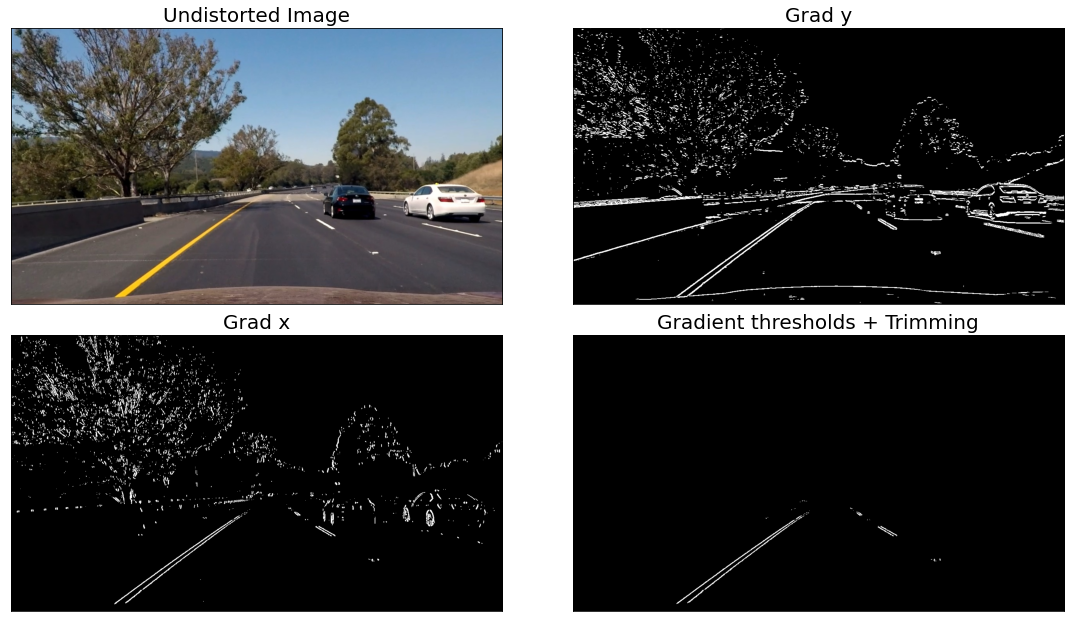

In [37]:
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = gradThres.abs_sobel_thresh(redimg_blur, orient='x', sobel_kernel=ksize, thresh=(50, 200))
grady = gradThres.abs_sobel_thresh(redimg_blur, orient='y', sobel_kernel=ksize, thresh=(50, 200))

# Combine gradient and trim roi
combined = np.zeros_like(gradx)
combined[((gradx == 1) & (grady == 1))] = 1
binary_grad = gradThres.region_of_interest(combined, roi_vertices)

# plot result
f, axes = plt.subplots(2, 2, figsize=(15, 9))
f.tight_layout()
axes[0,0].imshow(undimg)
axes[0,0].set_title('Undistorted Image', fontsize=20)

axes[1,0].imshow(gradx, cmap='gray')
axes[1,0].set_title('Grad x', fontsize=20)

axes[0,1].imshow(grady, cmap='gray')
axes[0,1].set_title('Grad y', fontsize=20)

axes[1,1].imshow(binary_grad, cmap='gray')
axes[1,1].set_title('Gradient thresholds + Trimming', fontsize=20)

for i in range(2):
    for j in range(2):
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Combine color thresholds and gradient thresholds
---
Almost done!

Now we have to combine color and gradient thresholds images. 

the result image assigns in `finimg`

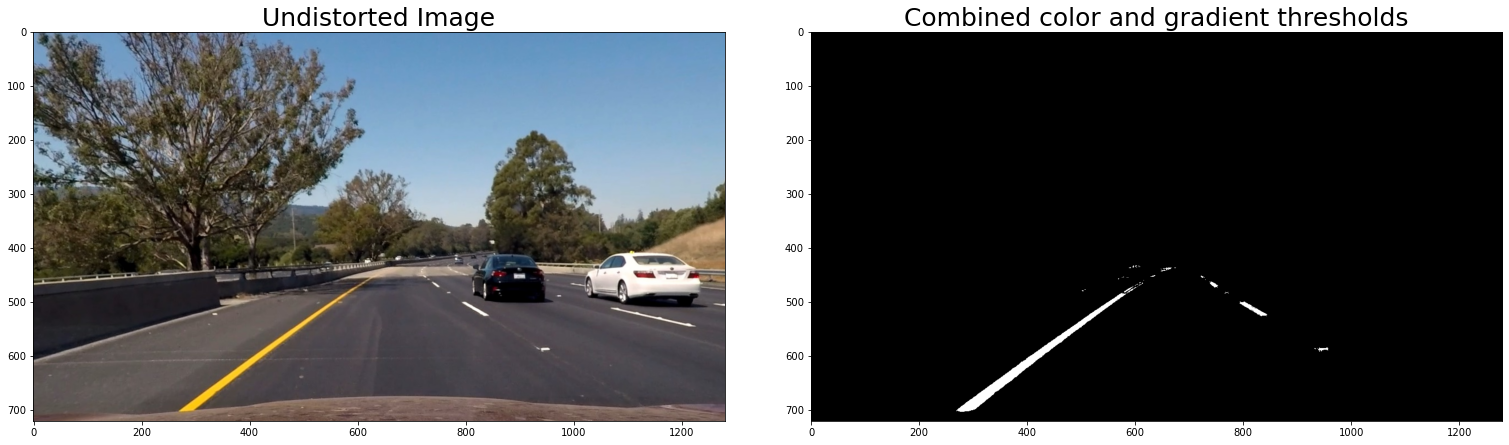

In [38]:
final_img = np.zeros_like(redimg)
final_img[(binary_grad == 1) | (binary_color ==1)] = 1

# plot result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 6))
f.tight_layout()
ax1.imshow(undimg)
ax1.set_title('Undistorted Image', fontsize=25)
plt.imshow(final_img, cmap='gray')
ax2.set_title('Combined color and gradient thresholds', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective Transform
---
Compute the perspective transform, M, given source and destination points:

```
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
```

Using this `M`, Warp `finimg` into `binray_warped`.

In [39]:
from scripts.PerspectiveTransform import PerspectiveTransform

In [40]:
perspective = PerspectiveTransform(final_img)

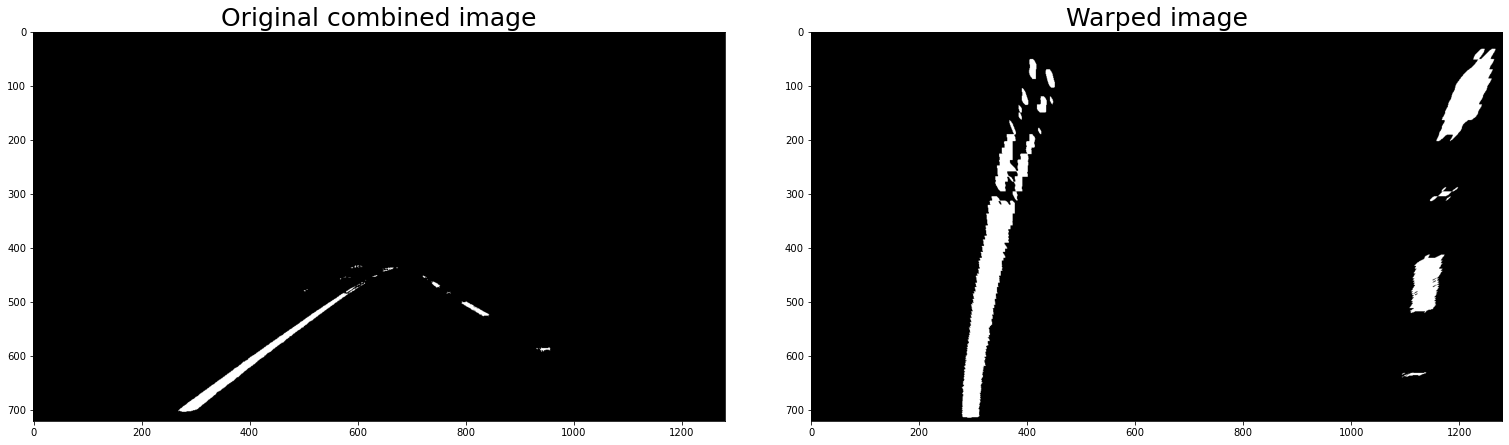

In [41]:
binary_warped = perspective.warp_image(final_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 6))
f.tight_layout()
ax1.imshow(final_img, cmap='gray')
ax1.set_title('Original combined image', fontsize=25)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Warped image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Find Lane Lines
---
From warped (bird eye's view) image, Left/Right polynomial function and radius of curvature are calculated.

The steps for finding lane lines are as follow:
1. Make **histogram** of bottom half of image.
2. Find the **peak** of the left and right havles of the histogram.
    They are starting point for te left and right lines.
3. Do **window search** from 0 to image height.
4. **Fit** the result points get from window search into **polynomial function.**
    Using conversions in x and y from pixels space to meters, calcualte the radius of curvatures and cross track error
5. Draw the result on warped image.
6. **Warp** the result image using inverse perspective transform `Minv`.

*In video processing, you do not have to search all the intervals, the algorithm **remembers the line position in the previous frame** and search only near that line position. With this method, the calculation time can be greatly improved.*

In [42]:
from scripts.FindLaneLine import *

In [43]:
out_img, window_img, result, left_fit, right_fit, left_curverad, right_curverad, cte = window_search(binary_warped, nwindows=10)
print('radius of curvature: %.3f m, %.3fm' % (left_curverad, right_curverad))
print('cte: %.3f m' % (cte))

radius of curvature: 812.479 m, 420.456m
cte: 0.397 m


(720.0, 0.0)

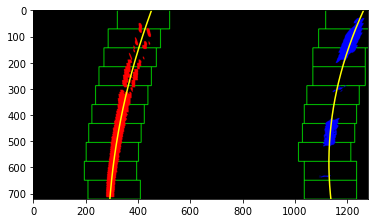

In [44]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720.0, 0.0)

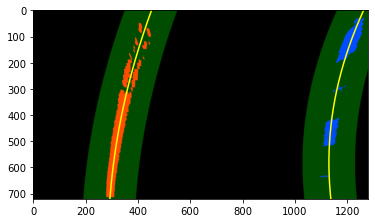

In [45]:
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

Skip the sliding windows step once you know where the lines are
Now you know where the lines are you have a fit! In the **next frame** of video you don't need to do a blind search again, but instead you can just **search in a margin** around the **previous line position** like this:

In [46]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

### Drawing
Once you have a good measurement of the line positions in warped space, it's time to project your measurement back down onto the road! Let's suppose, as in the previous example, you have a warped binary image called warped, and you have fit the lines with a polynomial and have arrays called ploty, left_fitx and right_fitx, which represent the x and y pixel values of the lines. You can then project those lines onto the original image as follows:


Text(0.5, 1.0, 'Detected Lane')

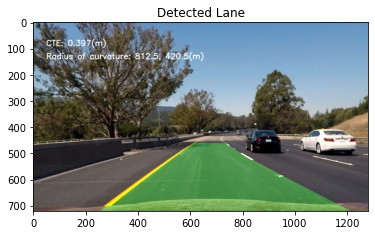

In [47]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = perspective.unwarp_image(color_warp)

# Combine the result with the original image
result = cv2.addWeighted(undimg, 1, newwarp, 0.3, 0)
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(result, 'CTE: %.3f(m)' %(cte) ,(50,90), font, 1,(255,255,255),2,cv2.LINE_AA)
cv2.putText(result, 'Radius of curvature: %.1f, %.1f(m)' %(left_curverad, right_curverad) ,(50,140), font, 1,(255,255,255),2,cv2.LINE_AA)
plt.imshow(result)
plt.title('Detected Lane')